## Zero-shot keyword spotting (KWS) using ImageBind on the Speech Commands dataset
---

Juan Carlo M. Santos

2018-00740

CoE 197Z Deep Learning

Project 2

---


In this project, we enable keyword spotting on the Speech Commands dataset using Meta's ImageBind model.

ImageBind is a model that enables multimodal capabalities (image, audio, text, depth, thermal, and IMU) by training solely on image-paired data to bind the modalities and learn a joint embedding space across the modalities.

By not training the model on the Speech Commands dataset, we are able to spot keywords in a zero-shot manner.

KWS accuracy with ImageBind was found to be 59.4% with `n_datapoints=64`. Accuracy was computed with the 'multiclass' accuracy function from the `torchmetrics` library.

Comparison with other KWS SOTA models is found at the end of the notebook.

References:
1. [roatienza/Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments)
2. [facebookresearch/ImageBind](https://github.com/facebookresearch/ImageBind)

### Clone KWS-ImageBind Repo
The  [helper repo](https://www.github.com/c-santos/KWS-ImageBind) contains needed files for ImageBind.
- `models` folder
- `data.py`
- `bpe`

NOTE: Comparison with SOTA models is at the end of the notebook.

In [ ]:
# Prepare Colab filesystem for cloning.
import os

print('Current directory:', os.getcwd())

if os.getcwd() == '/content/KWS-ImageBind':
  print('Moving out of repo directory')
  %cd ..

print('Directories: ', os.listdir())

if 'KWS-ImageBind' in os.listdir():
  print('Removing repo...')
  !rm -r KWS-ImageBind
  print('Repo deleted!')


In [ ]:
# Clone the helper repo.
!git clone -l -s https://github.com/c-santos/KWS-ImageBind.git KWS-ImageBind
%cd KWS-ImageBind
!ls

### Install and import dependencies

In [ ]:
%pip install pytorch_lightning
%pip install torchmetrics

# ImageBind dependencies
%pip install pytorchvideo
%pip install ftfy
%pip install timm
%pip install decord
%pip install einops
%pip install regex
%pip install fvcore
%pip install iopath
%pip install numpy
%pip install types-regex
%pip install mayavi
%pip install cartopy

# Dependencies for audio recording
!pip install ipywebrtc
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
import torch
import torchaudio, torchvision

import matplotlib.pyplot as plt
import librosa
import argparse
import numpy as np
import einops

from pytorch_lightning import LightningModule, Trainer, LightningDataModule, Callback

import torchmetrics
from torchvision.transforms import ToTensor

from torchaudio.datasets import SPEECHCOMMANDS

import IPython.display as ipd
from IPython.display import Markdown as md

In [ ]:
print(torch.cuda.is_available())
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

### Custom Silence and Unknown Dataset

We create a custom `silence` dataset. The dataset randomly samples background audio supplied in the KWS dataset. These files are under the `_background_noise_` folder.

We also create `unknown` dataset uses random audio samples from the train set but labelled as `unknown`.

The creation of these 2 datasets is described in the [KWS paper](https://arxiv.org/pdf/1804.03209.pdf) and implemented below.

We limit the number of samples to about the size of train dataset divided by 35 (the number of distinct words in the KWS dataset).

In [ ]:
# borrowed from https://github.com/roatienza/Deep-Learning-Experiments/blob/master/versions/2022/supervised/python/kws_demo.ipynb
class SilenceDataset(SPEECHCOMMANDS):
    def __init__(self, root):
        super(SilenceDataset, self).__init__(root, subset='training')
        self.len = len(self._walker) // 35
        path = os.path.join(self._path, torchaudio.datasets.speechcommands.EXCEPT_FOLDER)
        self.paths = [os.path.join(path, p) for p in os.listdir(path) if p.endswith('.wav')]

    def __getitem__(self, index):
        index = np.random.randint(0, len(self.paths))
        filepath = self.paths[index]
        waveform, sample_rate = torchaudio.load(filepath)
        return waveform, sample_rate, "silence", 0, 0

    def __len__(self):
        return self.len

class UnknownDataset(SPEECHCOMMANDS):
    def __init__(self, root):
        super(UnknownDataset, self).__init__(root, subset='training')
        self.len = len(self._walker) // 35

    def __getitem__(self, index):
        index = np.random.randint(0, len(self._walker))
        fileid = self._walker[index]
        waveform, sample_rate, _, speaker_id, utterance_number = torchaudio.datasets.speechcommands.load_speechcommands_item(fileid, self._path)
        return waveform, sample_rate, "unknown", speaker_id, utterance_number

    def __len__(self):
        return self.len

### The PyTorch Lightning Data Module for KWS

`KWSDataModule` cleanly separates the data handling from the model. The data module handles the datasets and dataloaders.

We use `torchaudio` `SPEECHCOMMANDS` dataset to load the training, testing and validation sets.

In [ ]:
# borrowed from https://github.com/roatienza/Deep-Learning-Experiments/blob/master/versions/2022/supervised/python/kws_demo.ipynb
class KWSDataModule(LightningDataModule):
    def __init__(self, path, batch_size=128, num_workers=0, n_fft=512,
                 n_mels=128, win_length=None, hop_length=256, class_dict={},
                 **kwargs):
        super().__init__(**kwargs)
        self.path = path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.n_fft = n_fft
        self.n_mels = n_mels
        self.win_length = win_length
        self.hop_length = hop_length
        self.class_dict = class_dict

    def prepare_data(self):
        # self.train_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
        #                                                         download=True,
        #                                                         subset='training')


        # self.val_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
        #                                                       download=True,
        #                                                       subset='validation')

        self.test_dataset = torchaudio.datasets.SPEECHCOMMANDS(self.path,
                                                               download=True,
                                                               subset='testing')

        silence_dataset = SilenceDataset(self.path)
        unknown_dataset = UnknownDataset(self.path)
        self.test_dataset = torch.utils.data.ConcatDataset([self.test_dataset, silence_dataset, unknown_dataset])

        _, sample_rate, _, _, _ = self.test_dataset[0]
        self.sample_rate = sample_rate
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                              n_fft=self.n_fft,
                                                              win_length=self.win_length,
                                                              hop_length=self.hop_length,
                                                              n_mels=self.n_mels,
                                                              power=2.0)

    def setup(self, stage=None):
        self.prepare_data()

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            collate_fn=self.collate_fn
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            collate_fn=self.collate_fn
        )

    def collate_fn(self, batch):
        mels = []
        labels = []
        wavs = []
        for sample in batch:
            waveform, sample_rate, label, speaker_id, utterance_number = sample
            # ensure that all waveforms are 2sec in length; if not pad with zeros
            if waveform.shape[-1] < sample_rate*2:
                waveform = torch.cat([waveform, torch.zeros((1, sample_rate*2 - waveform.shape[-1]))], dim=-1)
            elif waveform.shape[-1] > sample_rate*2:
                waveform = waveform[:,:sample_rate*2]

            # mel from power to db
            mels.append(ToTensor()(librosa.power_to_db(self.transform(waveform).squeeze().numpy(), ref=np.max)))
            labels.append(torch.tensor(self.class_dict[label]))
            wavs.append(waveform)

        mels = torch.stack(mels, dim=0)
        labels = torch.stack(labels)
        wavs = torch.stack(wavs)

        return mels, labels, wavs

### Program Arguments

The default configuration is shown below.


In [ ]:
# borrowed from https://github.com/roatienza/Deep-Learning-Experiments/blob/master/versions/2022/supervised/python/kws_demo.ipynb
def get_args():
    parser = argparse.ArgumentParser()
    # model training hyperparameters
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--max-epochs', type=int, default=30, metavar='N',
                        help='number of epochs to train (default: 30)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001)')

    # where dataset will be stored
    parser.add_argument("--path", type=str, default="data/speech_commands/")

    # 35 keywords + silence + unknown
    parser.add_argument("--num-classes", type=int, default=37)

    # mel spectrogram parameters
    parser.add_argument("--n-fft", type=int, default=1024)
    parser.add_argument("--n-mels", type=int, default=128)
    parser.add_argument("--win-length", type=int, default=None)
    parser.add_argument("--hop-length", type=int, default=512)

    # 16-bit fp model to reduce the size
    parser.add_argument("--precision", default=16)
    parser.add_argument("--accelerator", default='gpu')
    parser.add_argument("--devices", default=1)
    parser.add_argument("--num-workers", type=int, default=2)

    parser.add_argument("--no-wandb", default=False, action='store_true')

    args = parser.parse_args("")
    return args

### Downloading and importing the Speech Commands dataset.

CLASSES list is also defined.

In [ ]:
# borrowed from https://github.com/roatienza/Deep-Learning-Experiments/blob/master/versions/2022/supervised/python/kws_demo.ipynb
if __name__ == "__main__":

    args = get_args()
    CLASSES = ['silence', 'unknown', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow',
               'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no',
               'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
               'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

    # Class dictionary
    CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}
    IDX_TO_CLASS = {i: c for i, c in enumerate(CLASSES)}

    # Download Speech Commands dataset with PyTorch Lightning
    if not os.path.exists(args.path):
        os.makedirs(args.path, exist_ok=True)

        datamodule = KWSDataModule(batch_size=args.batch_size, num_workers=args.num_workers,
                                  path=args.path, n_fft=args.n_fft, n_mels=args.n_mels,
                                  win_length=args.win_length, hop_length=args.hop_length,
                                  class_dict=CLASS_TO_IDX)
        datamodule.setup()



### Initialize ImageBind model

- Imports needed modules to use ImageBind
- Initializes pretrained ImageBind model
- Downloads model checkpoint

In [ ]:
import data
from models import imagebind_model
from models.imagebind_model import ModalityType


In [ ]:
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

### Infer functions
Specific functions are made for random audio file inference, for user-recorded audio, and for statistics collection.

In [ ]:
def infer_stats(wav_file=None,
          sc_path=args.path,
          CLASSES=CLASSES,
          device=device,
          CLASS_TO_IDX=CLASS_TO_IDX,
          IDX_TO_CLASS=IDX_TO_CLASS):

  label = CLASSES[2:]

  # Get random audio if no wav_file is provided
  if wav_file is None:

    # list wav files given a folder
    label = CLASSES[2:]
    label = np.random.choice(label)

    path = os.path.join(args.path, "SpeechCommands/speech_commands_v0.02/")
    path = os.path.join(path, label)
    wav_files = [os.path.join(path, f)
                for f in os.listdir(path) if f.endswith('.wav')]

    # select random wav file
    wav_file = np.random.choice(wav_files)


  to_infer = [wav_file]

  inputs = {
    ModalityType.AUDIO: data.load_and_transform_audio_data(to_infer, device),
    ModalityType.TEXT: data.load_and_transform_text(CLASSES, device)
  }

  with torch.no_grad():
    embeddings = model(inputs)

  prediction = torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1)

  pred_idx = torch.argmax(prediction)
  pred = IDX_TO_CLASS[pred_idx.item()]

  ground_truth = [1 if i == label else 0 for i in CLASSES]
  ground_truth = torch.tensor(ground_truth).to(device)

  if type(label) == list:
    print(f"Prediction: {pred_idx.item()}. {pred}")
    ground_truth = None
  else:
    print(f"Ground Truth: {CLASS_TO_IDX[label]}. {label}, Prediction: {pred_idx.item()}. {pred}")

  return prediction.squeeze(), ground_truth, wav_file



In [ ]:
def infer_random():
  label = CLASSES[2:]
  label = np.random.choice(label)

  path = os.path.join(args.path, "SpeechCommands/speech_commands_v0.02/")
  path = os.path.join(path, label)
  wav_files = [os.path.join(path, f)
              for f in os.listdir(path) if f.endswith('.wav')]

  # select random wav file
  wav_file = np.random.choice(wav_files)

  to_infer = [wav_file]

  inputs = {
    ModalityType.AUDIO: data.load_and_transform_audio_data(to_infer, device),
    ModalityType.TEXT: data.load_and_transform_text(CLASSES, device)
  }

  with torch.no_grad():
    embeddings = model(inputs)

  prediction = torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1)

  pred_idx = torch.argmax(prediction)
  pred = IDX_TO_CLASS[pred_idx.item()]

  ground_truth = [1 if i == label else 0 for i in CLASSES]
  ground_truth = torch.tensor(ground_truth).to(device)

  pred_string = f"Ground Truth:\t\t{label}\nPrediction:\t\t{pred}"

  return pred_string, wav_file

In [ ]:
def infer_recording(audio):

  to_infer = [audio]

  inputs = {
    ModalityType.AUDIO: data.load_and_transform_audio_data(to_infer, device),
    ModalityType.TEXT: data.load_and_transform_text(CLASSES, device)
  }

  with torch.no_grad():
    embeddings = model(inputs)

  prediction = torch.softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, dim=-1)

  pred_idx = torch.argmax(prediction)
  pred = IDX_TO_CLASS[pred_idx.item()]

  pred_string = f"Prediction:\t{pred}"
  print(pred_string)

  return pred_string

### Main statistics function
Uses multiclass accuracy to compute accuracy of ImageBind model in zero-shot KWS of the Speech Commands dataset.

Configure `n_batches` and `n_data_points` parameters.

In [ ]:
def statistics(n_batches, n_data_points):
  # Multiclass Accuracy
  metric = torchmetrics.Accuracy(task="multiclass", num_classes=37).to(device)

  n_batches = n_batches
  for i in range(n_batches):
    preds, target, wav_file = infer_stats()
    # metric on current batch
    acc = metric(preds, target)
    print(f"Accuracy on batch {i}: {acc}")

  # metric on all batches using custom accumulation
  acc = metric.compute()
  print(f"Accuracy on all data: {acc}")

  # Reseting internal state such that metric ready for new data
  metric.reset()
  return acc.item()


### Demo using Gradio

Run each cell below to show GUI of demo.

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

random_tab = gr.Interface(fn=infer_random,
                    inputs = [

                    ],
                    outputs = [
                        'text',
                        gr.Audio(type='filepath'),
                    ],)

record_tab = gr.Interface(fn=infer_recording,
                           inputs = [
                              gr.Audio(source='microphone', type='filepath'),
                           ],
                           outputs = [
                              'text'
                           ],
                          )

stats_tab = gr.Interface(fn=statistics,
                         inputs = [
                            gr.Slider(0,100),
                         ],
                         outputs = [
                         'text',
                         ],)

demo = gr.TabbedInterface([random_tab, record_tab, stats_tab],['Random audio', 'Recorded audio', 'Statistics'])


demo.launch()


### Comparison to SOTA models that use Speech Commands dataset


| Model Name       | Accuracy | Shot      | Supervision | Link                                                   |
|------------------|----------|-----------|-------------|--------------------------------------------------------|
| TripetLoss-res15 | 98.37%   | Not       | Supervised  | https://arxiv.org/ftp/arxiv/papers/2101/2101.04792.pdf |
| BC-ResNet        | 98.7%    | Not       | Supervised  | https://arxiv.org/pdf/2106.04140v3.pdf                 |
| ImageBind (ours) | 59.4%      | Zero-shot | Unsupervised (see notes below)   | https://arxiv.org/pdf/2305.05665.pdf  |

<sub>data from [paperswithcode.com](https://paperswithcode.com/sota/keyword-spotting-on-google-speech-commands)</sub>


Seen from the table, the large gap with SOTA models is noticeable. However, it is important to note that these models were trained on the Speech Commands dataset, unlike with ImageBind which is performing zero-shot KWS and learns from the joint embedding space (almost self-supervised).




Notes from ImageBind Paper:
- Foundation of ImageBind is a vision transformer.
- "ImageBind unlocks zero-shot classification for modalities without paired text data."
- Self-supervised learning is used in pairing audio, depth, thermal, and IMU with images
- Modalities are paired with images during training. Cross-modality alignment emerges from the embedding space.
- Supervised for image and text pairs (ViT-H from OpenCLIP)
- Supervised for audio and video pairs (AudioSet dataset)
- ImageBind is able to to do zero-shot audio and text classification from its cross modality capabilities i.e training image-text and image-audio pairs.
- For the task of **audio to text retrieval**, ImageBind is **self-supervised**, and ***emergent* zero-shot**
- It is self-supervised since the joint embedding space that it generates is a product of the supervised learning done on image-paired data.


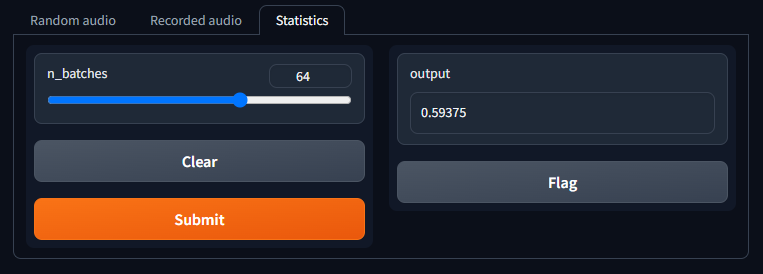